We'll use this notebook to figure out how well the the pre-trained [detectree classifier](https://github.com/martibosch/detectree) works on USDA National Agriculture Imagery Program (NAIP) [satellite data](https://naip-usdaonline.hub.arcgis.com/).


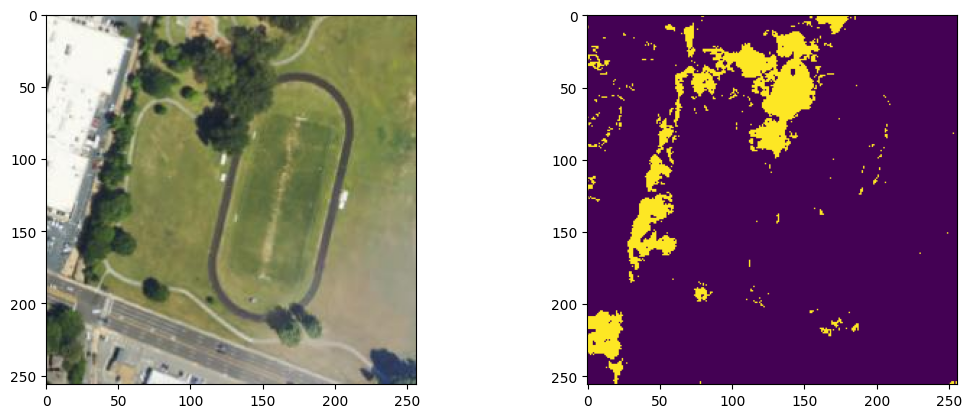

In [ ]:
import os
import detectree as dtr
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot
import warnings
warnings.filterwarnings("ignore")

img_path = f"{os.getcwd()}/../data/NaipSat/images/naip_17_51858_32783.png"

y_pred = dtr.Classifier().predict_img(img_path)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(img_path) as src:
    plot.show(src, ax=axes[0])
axes[1].imshow(y_pred)

Seems to work rather well on properly lit images. Let's try with another image:

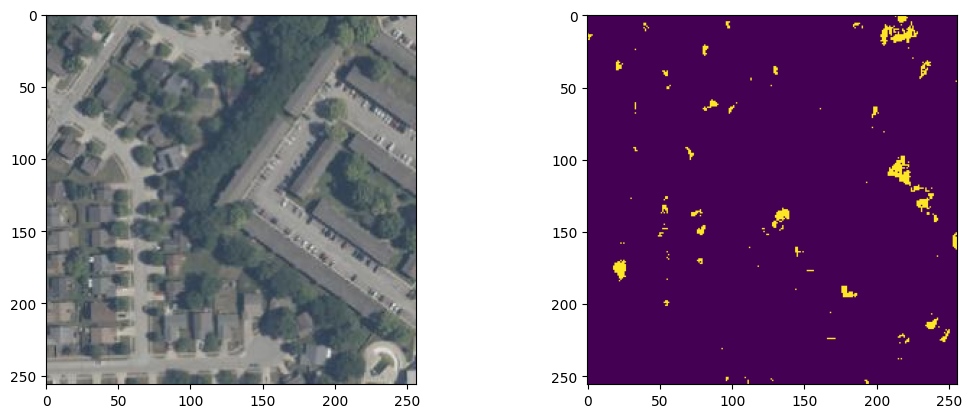

In [31]:
img_path = f"{os.getcwd()}/../data/NaipSat/images/naip_17_49728_34130.png"

y_pred = dtr.Classifier().predict_img(img_path)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(img_path) as src:
    plot.show(src, ax=axes[0])
axes[1].imshow(y_pred)

Oops, this seems to miss most tree-covered areas. Can we improve the result by adjusting the contrast?

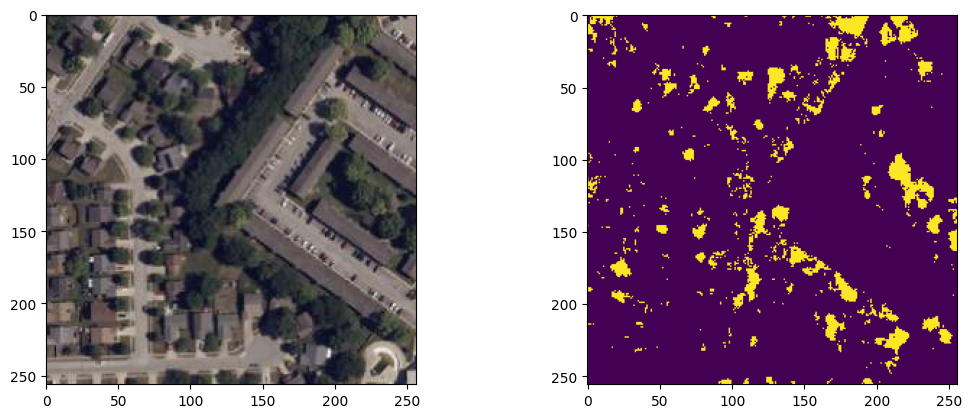

In [35]:
from PIL import Image, ImageOps

img_name = "naip_17_49728_34130"
img_path = f"{os.getcwd()}/../data/NaipSat/images/{img_name}.png"
enh_path = f"{os.getcwd()}/../data/NaipSat/images/enhanced/{img_name}_c.png"
im = Image.open(img_path)
im = ImageOps.autocontrast(im)
im.save(enh_path)

y_pred = dtr.Classifier().predict_img(enh_path)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(enh_path) as src:
    plot.show(src, ax=axes[0])
axes[1].imshow(y_pred)

Yep, that's better. How about sharpening the image?

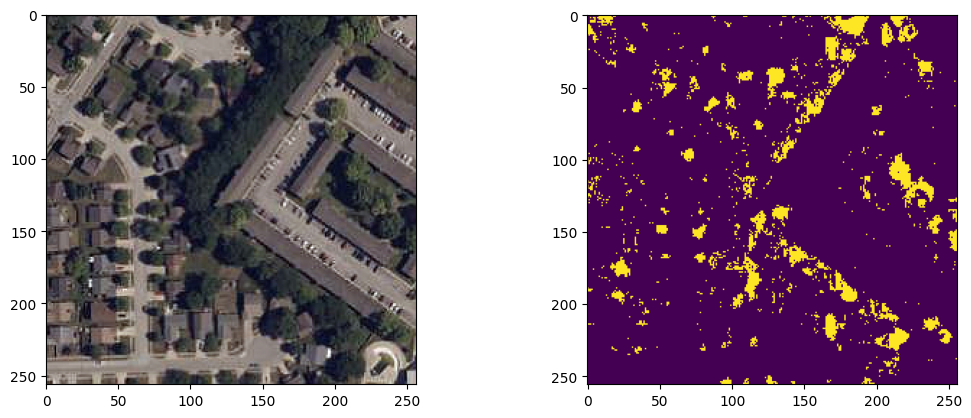

In [36]:
from PIL import ImageEnhance

img_name = "naip_17_49728_34130"
img_path = f"{os.getcwd()}/../data/NaipSat/images/{img_name}.png"
enh_path = f"{os.getcwd()}/../data/NaipSat/images/enhanced/{img_name}_cs.png"
im = Image.open(img_path)
im = ImageOps.autocontrast(im)
im = ImageEnhance.Sharpness(im).enhance(2.0)
im.save(enh_path)

y_pred = dtr.Classifier().predict_img(enh_path)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(enh_path) as src:
    plot.show(src, ax=axes[0])
axes[1].imshow(y_pred)

Nope, that just makes it slightly more noisy. How about contrast *plus* brightness?

Reference brightness: 0.5517183512369792
Image brightness 0.4373428225517273
Adjustment factor: 1.2615237355855407


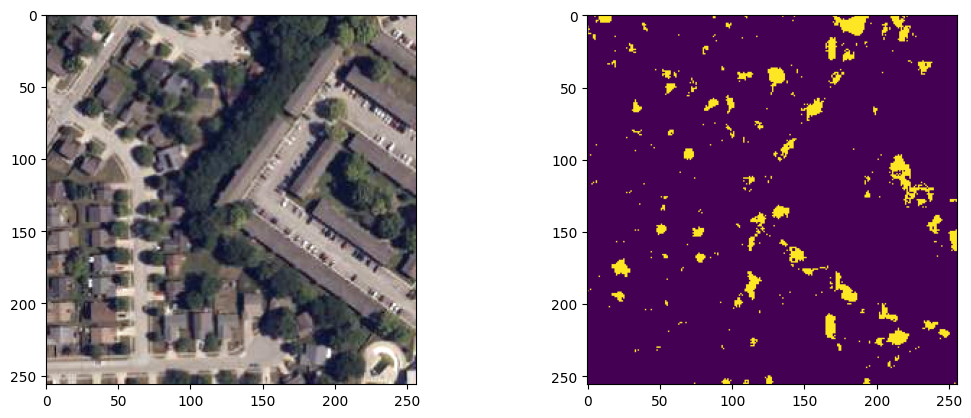

In [42]:
from urllib import request


def calc_brightness(image):
    grayscale_img = image.convert("L")
    hist = grayscale_img.histogram()
    pixels = sum(hist)
    brightness = scale = len(hist)

    for index in range(0, scale):
        ratio = hist[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 else brightness / scale


# Get the reference brightness
tile_filename = "tile.png"
if not os.path.exists(tile_filename):
    tile_url = (
        "https://wms.geo.admin.ch/?SERVICE=WMS&REQUEST=GetMap&VERSION=1.3.0&"
        "FORMAT=image/png&LAYERS=ch.swisstopo.images-swissimage&CRS=EPSG:2056"
        "&BBOX=2532980,1152150,2533380,1152450&WIDTH=800&HEIGHT=600"
    )
    request.urlretrieve(tile_url, tile_filename)
ref_img = Image.open(tile_filename)
ref_br = calc_brightness(ref_img)
print("Reference brightness:", ref_br)

img_name = "naip_17_49728_34130"
img_path = f"{os.getcwd()}/../data/NaipSat/images/{img_name}.png"
enh_path = f"{os.getcwd()}/../data/NaipSat/images/enhanced/{img_name}_cs.png"
im = Image.open(img_path)
img_br = calc_brightness(im)
print("Image brightness", img_br)
br_adj = ref_br / img_br
print("Adjustment factor:", br_adj)
im = ImageOps.autocontrast(im)
im = ImageEnhance.Brightness(im).enhance(br_adj)
im.save(enh_path)

y_pred = dtr.Classifier().predict_img(enh_path)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(enh_path) as src:
    plot.show(src, ax=axes[0])
axes[1].imshow(y_pred)

Nah, that just concentrates the blobs and seems to lose most of the areas gained from applying autocontrast before. So we'll stick to just using autocontrast.